## Test PSF measurement in the stack

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

3


Make a couple of test images to test the PSF measurement on...

In [37]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.
breakLimit = 1.050

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=21)

Compare `psfex` and `pca` PSFs.

(234.22, 262.52)
(41, 41) (41, 41)
0.999999974389
(235.88, 233.87)
(41, 41) (31, 31)
1.00019083464


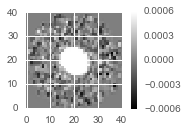

In [38]:
reload(dit)
res = dit.measurePsf(testObj.im2.asAfwExposure(), measurePsfAlg='psfex')
print res.psf.getAveragePosition()
psf = res.psf.computeImage()
print testObj.im2.psf.shape, psf.getDimensions()
print psf.getArray().sum()

res2 = dit.measurePsf(testObj.im2.asAfwExposure(), measurePsfAlg='pca')
print res2.psf.getAveragePosition()
psf2 = res2.psf.computeImage()
print testObj.im2.psf.shape, psf2.getDimensions()
print psf2.getArray().sum()

dit.plotImageGrid((res.psf.computeImage().getArray(),)) #, clim=(-0.001,0.001))

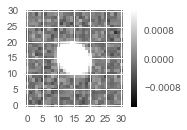

In [39]:
dit.plotImageGrid((res2.psf.computeImage().getArray(),)) #, clim=(-0.001,0.001))

In [40]:
print dit.computeMoments(testObj.im2.psf)
print dit.computeMoments(res.psf.computeImage().getArray())
print dit.computeMoments(res2.psf.computeImage().getArray())

(20.0, 20.000000000000004)
(20.16812639662923, 19.556708102951127)
(14.898021661372065, 14.923783917930344)


See how it works on a crowded field.

In [41]:
reload(dit)
testObj2 = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=500, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=21)

#fig = plt.figure(1, (12, 12))
#dit.plotImageGrid((testObj2.im1.im,))

In [42]:
reload(dit)
res = dit.measurePsf(testObj2.im1.asAfwExposure(), detectThresh=10.0, measurePsfAlg='psfex')

(41, 41) (41, 41)
0.999998725944
0.999998725944
1.0
(20, 20)
(20, 20)
0.018181947047


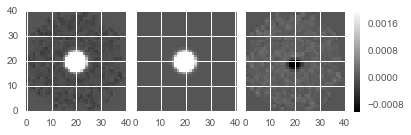

In [43]:
reload(dit)
psf1 = res.psf.computeImage()
print testObj2.im1.psf.shape, psf1.getDimensions()
print psf1.getArray().sum()

psf1a = psf1.getArray().copy() #/ np.abs(psf2.getArray()).sum()
psf1anorm = psf1a[np.abs(psf1a)>1e-3].sum()
print psf1a.sum()
psf1a /= psf1anorm

actualPsf1 = dit.makePsf(21, [1.6, 1.6], offset=[-0.35, -0.275], theta=0.)
print actualPsf1.sum()

print np.unravel_index(np.argmax(psf1a), psf1a.shape)
print np.unravel_index(np.argmax(actualPsf1), actualPsf1.shape)
#print ((actualPsf1 - psf1.getArray())**2.).sum()
print np.sqrt(((psf1a - actualPsf1)**2.).mean()) * 100.  # compare with the violinplots from ...-Copy6.ipynb

dit.plotImageGrid((psf1a, actualPsf1, actualPsf1 - psf1a), clim=(-0.001,0.002))

In [44]:
reload(dit)
res2 = dit.measurePsf(testObj2.im2.asAfwExposure(), detectThresh=10.0, measurePsfAlg='psfex')

In [45]:
print dit.computeMoments(testObj2.im1.psf)
print dit.computeMoments(testObj2.im2.psf)
print dit.computeMoments(res.psf.computeImage().getArray())
print dit.computeMoments(res2.psf.computeImage().getArray())

(20.0, 20.000000000000004)
(20.0, 20.000000000000004)
(19.822969609511077, 19.596298945851927)
(20.020332772128079, 19.852783269605659)


(25, 25) (41, 41)
1.00000164
1.14996718813 1.00000164
0.869591454715
1.0
(20, 20)
(20, 20)
0.0193780367635


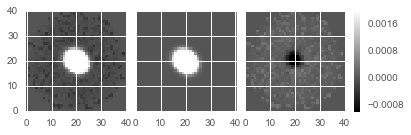

In [9]:
reload(dit)
psf2 = res2.psf.computeImage()
print testObj2.im2.psf.shape, psf2.getDimensions()
print psf2.getArray().sum()

psf2a = psf2.getArray().copy() #/ np.abs(psf2.getArray()).sum()
psf2anorm = psf2a[np.abs(psf2a)>=1e-3].sum()
print psf2anorm, psf2a.sum()
psf2a /= psf2anorm
print psf2a.sum()

actualPsf2 = dit.makePsf(21, [1.8, 2.2], offset=[-0.2, 0.05], theta=-45.)
print actualPsf2.sum()

print np.unravel_index(np.argmax(psf2a), psf2a.shape)
print np.unravel_index(np.argmax(actualPsf2), actualPsf2.shape)
print np.sqrt(((psf2a - actualPsf2)**2.).mean()) * 100.  # compare with the violinplots from ...-Copy6.ipynb

dit.plotImageGrid((psf2a, actualPsf2, actualPsf2 - psf2a), clim=(-0.001,0.002))

In [12]:
reload(dit)

sh = res.psf.computeShape(); print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()
sh = res2.psf.computeShape(); print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()

sh = dit.arrayToAfwPsf(actualPsf1).computeShape(); 
print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()
sh = dit.arrayToAfwPsf(actualPsf2).computeShape()
print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()

1.5951322733 2.54542689293 2.5434688718 0.00192040730385
1.97213905059 3.97103239959 3.96260392584 -0.780206246743
1.63121025049 2.63848297727 2.68718725146 0.0999584609965
1.99490612919 4.04245576994 4.08013818567 -0.810037241756


1.0 1.00000164 1.32945430804
1.14996718813 1.00000164
0.869591454715


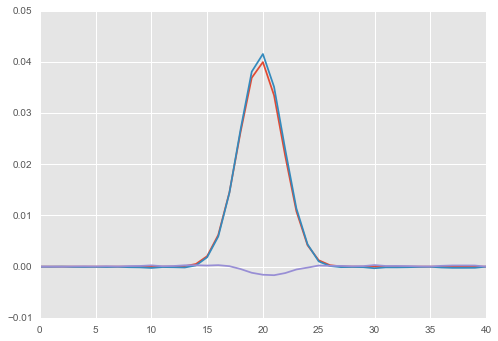

In [13]:
print np.abs(actualPsf2).sum(), psf2.getArray().sum(), np.abs(psf2.getArray()).sum()
psf2a = psf2.getArray().copy() #/ np.abs(psf2.getArray()).sum()
psf2anorm = psf2a[np.abs(psf2a)>=1e-3].sum()
print psf2anorm, psf2a.sum()
psf2a /= psf2anorm
print psf2a.sum()

plt.plot((actualPsf2)[:,20])
plt.plot((psf2a)[:,20])
plt.plot((actualPsf2 - psf2a)[:,20])

### Last test - a really crowded field.

In [14]:
reload(dit)
testObj3 = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=5000, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

#fig = plt.figure(1, (12, 12))
#dit.plotImageGrid((testObj2.im1.im,))

In [15]:
reload(dit)
res3 = dit.measurePsf(testObj3.im1.asAfwExposure(), detectThresh=5.0, measurePsfAlg='psfex')

(25, 25) (41, 41)
1.00000004
1.00000004
1.0
(20, 20)
(20, 20)
0.186803683976


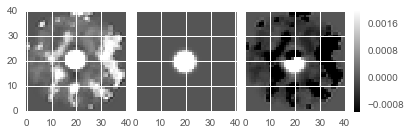

In [16]:
reload(dit)
psf3 = res3.psf.computeImage()
print testObj3.im1.psf.shape, psf3.getDimensions()
print psf3.getArray().sum()

psf3a = psf3.getArray().copy() #/ np.abs(psf2.getArray()).sum()
psf3anorm = psf3a[np.abs(psf3a)>1e-3].sum()
print psf3a.sum()
psf3a /= psf3anorm

actualPsf3 = dit.makePsf(21, [1.6, 1.6], offset=[0., 0.], theta=0.)
print actualPsf3.sum()

print np.unravel_index(np.argmax(psf3a), psf3a.shape)
print np.unravel_index(np.argmax(actualPsf3), actualPsf3.shape)
#print ((actualPsf1 - psf1.getArray())**2.).sum()
print np.sqrt(((psf3a - actualPsf3)**2.).mean()) * 100.  # compare with the violinplots from ...-Copy6.ipynb

dit.plotImageGrid((psf3a, actualPsf3, actualPsf3 - psf3a), clim=(-0.001,0.002))

In [21]:
res3a = dit.measurePsf(testObj3.im2.asAfwExposure(), detectThresh=5.0, measurePsfAlg='psfex')
actualPsf3a = dit.makePsf(21, [1.8, 2.2], offset=[0., 0.], theta=-45.)

In [22]:
sh = res3.psf.computeShape(); print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()
sh = res3a.psf.computeShape(); print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()

sh = dit.arrayToAfwPsf(actualPsf3).computeShape(); 
print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()
sh = dit.arrayToAfwPsf(actualPsf3a).computeShape(); 
print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()

1.59409749864 2.56385639452 2.51866730237 -0.00860412649477
2.17297615047 5.20942185391 4.47248201013 -1.00170399024
1.63121025049 2.63848297727 2.68718725146 0.0999584609965
1.98996163727 4.03994623804 4.03994623804 -0.799989278877


1.0 1.00000004 1.01184776556
0.699625628069 0.869591454715
1.42933591892


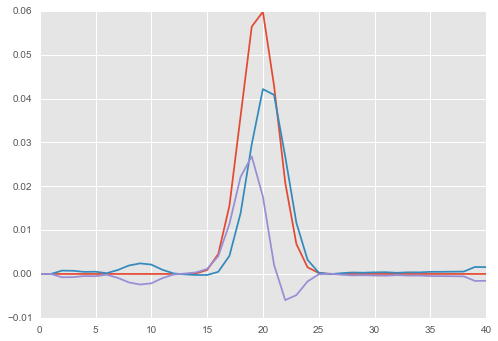

In [23]:
print np.abs(actualPsf3).sum(), psf3.getArray().sum(), np.abs(psf3.getArray()).sum()
psf3a = psf3.getArray().copy() #/ np.abs(psf2.getArray()).sum()
psf3anorm = psf3a[np.abs(psf3a)>=1e-3].sum()
print psf3anorm, psf2a.sum()
psf3a /= psf3anorm
print psf3a.sum()

plt.plot((actualPsf3)[:,20])
plt.plot((psf3a)[:,20])
plt.plot((actualPsf3 - psf3a)[:,20])

In [35]:
xgrid, ygrid = np.meshgrid(np.arange(0, psf3a.shape[0]), np.arange(0, psf3a.shape[1]))
xmoment = np.average(xgrid, weights=psf3a)
ymoment = np.average(ygrid, weights=psf3a)
print xmoment, ymoment

reload(dit)
print dit.computeMoments(psf3a)
print dit.computeMoments(actualPsf3)

21.1002462645 20.2570279059
(21.100246264526518, 20.257027905863325)
(19.725000000000001, 19.650000000000009)


In [50]:
def runTest(n_sources=500, seed=66):
    out = None
    try:
        testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                             offset=[0,0], psf_yvary_factor=0., 
                             #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                             varFlux2=[1500., 1500., 1500.],
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(500,30000), 
                             seed=seed, psfSize=21)
        
        try:
            res1 = dit.measurePsf(testObj.im1.asAfwExposure(), detectThresh=5.0, measurePsfAlg='psfex')
            psf1 = res1.psf.computeImage()
            psf1a = psf1.getArray().copy() #/ np.abs(psf2.getArray()).sum()
            psf1anorm = psf1a[np.abs(psf1a)>=1e-3].sum()
            psf1a /= psf1anorm
            actualPsf1 = testObj.im1.psf #dit.makePsf(21, [1.6, 1.6], offset=[0., 0.], theta=0.)
            rms1 = np.sqrt(((psf1a - actualPsf1)**2.).mean()) #* 100.
            rad1 = res1.psf.computeShape().getDeterminantRadius()
            sh = dit.arrayToAfwPsf(actualPsf1).computeShape()
            inputShape1 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            sh = res1.psf.computeShape()
            shape1 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            moments1 = dit.computeMoments(psf1.getArray())
        except:
            rms1 = shape1 = inputShape1 = None

        try:
            res2 = dit.measurePsf(testObj.im2.asAfwExposure(), detectThresh=5.0, measurePsfAlg='psfex')
            psf2 = res2.psf.computeImage()
            psf2a = psf2.getArray().copy() #/ np.abs(psf2.getArray()).sum()
            psf2anorm = psf2a[np.abs(psf2a)>=1e-3].sum()
            psf2a /= psf2anorm
            actualPsf2 = testObj.im2.psf #dit.makePsf(21, [1.8, 2.2], offset=[0., 0.], theta=-45.)
            rms2 = np.sqrt(((psf2a - actualPsf2)**2.).mean()) #* 100.
            rad2 = res2.psf.computeShape().getDeterminantRadius()
            sh = dit.arrayToAfwPsf(actualPsf2).computeShape()
            inputShape2 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            sh = res2.psf.computeShape()
            shape2 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            moments2 = dit.computeMoments(psf2.getArray())
        except:
            rms2 = shape2 = inputShape2 = None

        out = {'psf1': psf1.getArray(), 'psf2': psf2.getArray(),
               'inputPsf1': actualPsf1, 'inputPsf2': actualPsf2,
               'rms1': rms1, 'rms2': rms2, 
               'shape1': shape1, 'shape2': shape2,
               'inputShape1': inputShape1, 'inputShape2': inputShape2,
               'moments1': moments1, 'moments2': moments2,
               'nSources': n_sources}
    except:
        pass
    return out

In [ ]:
tmp = runTest(n_sources=50, seed=1);
#tmp

In [ ]:
inputs = [(i, j) for i in np.arange(50, 5000, 100) for j in np.arange(1, 10)]
print len(inputs)
testResults1 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(n_sources=i[0], seed=i[1]) \
                                                     for i in inputs)
import cPickle; import gzip
cPickle.dump(testResults1, gzip.GzipFile('27. psf measurement evaluation - part 2.p.gz', 'wb'))

450


In [28]:
ns = np.array([inputs[i][0] for i in np.arange(len(inputs)) if testResults1[i] is not None])
tr = [t for t in testResults1 if t is not None]
print len(tr)
tr = {'nSources': ns,
      'rms1': np.array([t['rms1'] for t in tr])*100.,
      'rms2': np.array([t['rms2'] for t in tr])*100.,
      'rad1diff': np.array([t['shape1'][0] - t['inputShape1'][0] for t in tr]),
      'rad2diff': np.array([t['shape2'][0] - t['inputShape2'][0] for t in tr])}
tr = pd.DataFrame(tr)
sizeme(tr.head())

450


,nSources,rad1diff,rad2diff,rms1,rms2
0,50,0.000981,0.003119,0.088620,0.018058
1,50,0.001589,0.006198,0.109066,0.050011
2,50,0.002818,-0.001879,0.075323,0.043697
3,50,-0.000253,0.006356,0.070538,0.030867
4,50,0.001571,0.000626,0.084321,0.045548


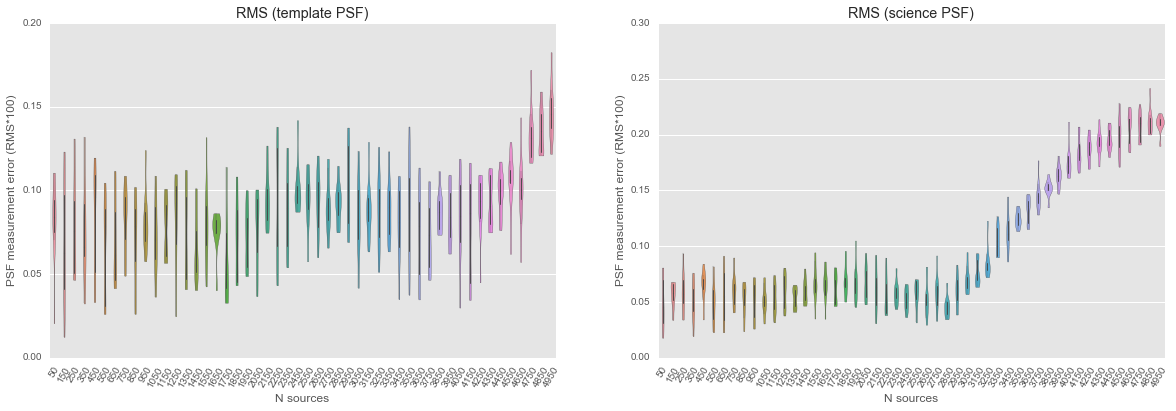

In [29]:
matplotlib.rcParams['figure.figsize'] = (20.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

g = sns.violinplot(x='nSources', y='rms1', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, ax=axes[0])
g.set_title('RMS (template PSF)')
g.set_ylabel('PSF measurement error (RMS*100)')
g.set_xlabel('N sources')
g.set_xticklabels(g.get_xticklabels(), rotation=60);

g = sns.violinplot(x='nSources', y='rms2', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, ax=axes[1])
g.set_title('RMS (science PSF)')
g.set_ylabel('PSF measurement error (RMS*100)')
g.set_xlabel('N sources')
g.set_xticklabels(g.get_xticklabels(), rotation=60);

## Recall that ZOGY seems to break when (RMS*100) > 0.045.

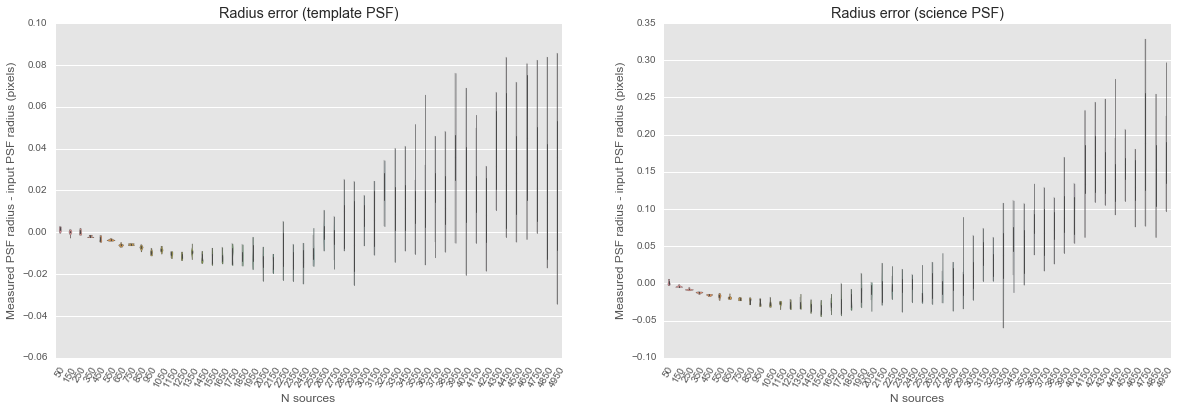

In [32]:
matplotlib.rcParams['figure.figsize'] = (20.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

g = sns.violinplot(x='nSources', y='rad1diff', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, ax=axes[0])
g.set_title('Radius error (template PSF)')
g.set_ylabel('Measured PSF radius - input PSF radius (pixels)')
g.set_xlabel('N sources')
g.set_xticklabels(g.get_xticklabels(), rotation=60);

g = sns.violinplot(x='nSources', y='rad2diff', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, ax=axes[1])
g.set_title('Radius error (science PSF)')
g.set_ylabel('Measured PSF radius - input PSF radius (pixels)')
g.set_xlabel('N sources')
g.set_xticklabels(g.get_xticklabels(), rotation=60);